# Time Series Analysis - Part 3 :  ARMA and ARIMA models

In this third case, we combine the Autoregressive models and Moving Average models we studied in the previous notebook to go one step forward producing a more sophisticated models - Auto Regressive Moving Average(ARMA) and Auto Regressive Integrated Moving Average(ARIMA) models.


In [ ]:
!pip install yahooquery

In [7]:
import os
import sys

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

from yahooquery import Ticker
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [6]:
def fetch_yahoo_data(ticker: str, start_date: str, end_date: str, interval: str = "1d") -> pd.DataFrame:
    """
    Downloads historical data for a financial asset from Yahoo Finance using yahooquery.

    Parameters:
    - ticker (str): Asset symbol (e.g., 'AAPL' for Apple, 'TSLA' for Tesla).
    - start_date (str): Start date in 'YYYY-MM-DD' format.
    - end_date (str): End date in 'YYYY-MM-DD' format.
    - interval (str, optional): Time interval ('1d', '1wk', '1mo', '1h', etc.).
      Possible values: ['1m', '2m', '5m', '15m', '30m', '1h', '1d', '5d', '1wk', '1mo', '3mo']

    Returns:
    - pd.DataFrame: DataFrame with columns ['open', 'high', 'low', 'close', 'adjclose', 'volume'].
    """
    try:
        asset = Ticker(ticker)
        data = asset.history(start=start_date, end=end_date, interval=interval)
        if data.empty:
            raise ValueError("No data found for the specified date range.")
        return data.reset_index()
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return pd.DataFrame()

In [8]:
def fetch_closing_prices(tickers: list, start_date: str, end_date: str, interval: str = "1d") -> pd.DataFrame:
    """
    Fetches the closing prices for multiple tickers and returns a DataFrame.

    Parameters:
    - tickers (list): List of asset symbols.
    - start_date (str): Start date in 'YYYY-MM-DD' format.
    - end_date (str): End date in 'YYYY-MM-DD' format.
    - interval (str, optional): Time interval ('1d', '1wk', '1mo', '1h', etc.).

    Returns:
    - pd.DataFrame: DataFrame where each column is a ticker and rows represent closing prices over time.
    """
    closing_prices = pd.DataFrame()
    for ticker in tickers:
        data = fetch_yahoo_data(ticker, start_date, end_date, interval)
        if not data.empty:
            closing_prices[ticker] = data.set_index("date")["close"]
    return closing_prices

In [9]:
# Usage example
if __name__ == "__main__":
    tickers = ["AAPL", "MSFT", "^GSPC"]
    start_date = "2008-01-01"
    end_date = "2025-01-01"
    data = fetch_closing_prices(tickers, start_date, end_date)
    print(data.head())

/usr/local/lib/python3.11/dist-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")
/usr/local/lib/python3.11/dist-packages/yahooquery/ticker.py:1333: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["dividends"].fillna(0, inplace=True)
/usr/local/lib/python3.11/dist-packages/yahooquery/ticker.py:1335: FutureWarning: A value is trying to be set on a copy of a Dat

                AAPL       MSFT        ^GSPC
date                                        
2008-01-02  6.958571  35.220001  1447.160034
2008-01-03  6.961786  35.369999  1447.160034
2008-01-04  6.430357  34.380001  1411.630005
2008-01-07  6.344286  34.610001  1416.180054
2008-01-08  6.116071  33.450001  1390.189941


/usr/local/lib/python3.11/dist-packages/yahooquery/utils/__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


In [19]:
lrets = np.log(data / data.shift(1)).fillna(0)
lrets.columns = ['AAPL', 'MSFT','SPX']

In [10]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    """
    Generates a set of diagnostic plots for a time series.

    Parameters:
    - y (array-like or pd.Series): Time series data.
    - lags (int, optional): Number of lags to include in the ACF and PACF plots.
    - figsize (tuple, optional): Figure size, default is (15, 10).
    - style (str, optional): Matplotlib style for plotting, default is 'bmh'.

    The function generates the following plots:
    1. Time series plot.
    2. Autocorrelation function (ACF) plot.
    3. Partial autocorrelation function (PACF) plot.
    4. Quantile-Quantile (QQ) plot for normality assessment.
    5. Probability plot.

    Returns:
    - None: Displays the plots.

    Example:
    >>> import numpy as np
    >>> import pandas as pd
    >>> np.random.seed(42)
    >>> data = np.random.randn(100)
    >>> tsplot(pd.Series(data), lags=20)
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

### Autoregressive Moving Average Models - ARMA(p, q)

ARMA model is simply the merger between AR(p) and MA(q) models:

* AR(p) models try to capture (explain) the momentum and mean reversion effects often observed in trading markets (market participant effects).
* MA(q) models try to capture (explain) the shock effects observed in the white noise terms. These shock effects could be thought of as unexpected events affecting the observation process e.g. Surprise earnings, A terrorist attack, etc.

Hence, an ARMA model attempts to capture both of these aspects when modelling financial time series. Note that an ARMA model does not take into account volatility clustering, a key empirical phenomena of many financial time series which we will discuss later.

$$x_t=\alpha_1x_{t-1}+…+\alpha_px_{t-p}+w_t+\beta_1w_{t-1}+…+\beta_qw_{t-q}$$

Where $w_t$ is white noise with $E(w_t)=0$ and variance $\sigma^2$

An ARMA model will often require fewer parameters than an AR(p) or MA(q) model alone. That is, it is redundant in its parameters

Let's simulate an ARMA(2, 2) process with given parameters, then fit an ARMA(2, 2) model and see if it can correctly estimate those parameters. Set alphas equal to [0.5,-0.25] and betas equal to [0.5,-0.3].

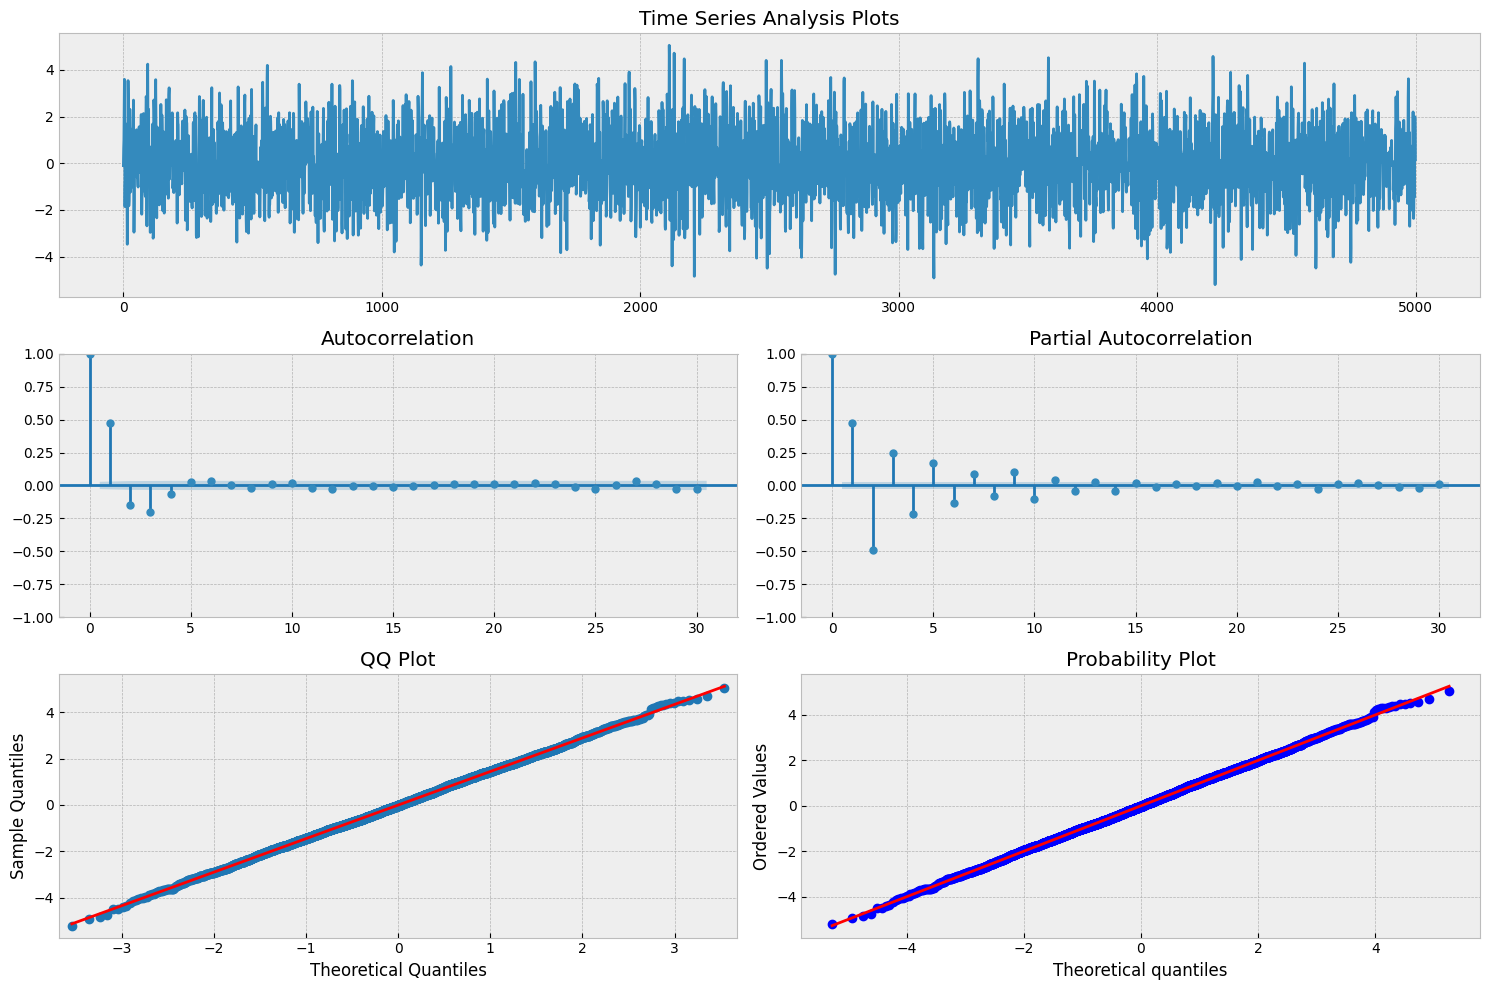

In [11]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag)

In [13]:
import statsmodels.api as sm

# Ajustar modelo ARMA(2,2) usando ARIMA con d=0
mdl = sm.tsa.ARIMA(arma22, order=(2, 0, 2)).fit()

# Mostrar resumen del modelo
print(mdl.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5000
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -7120.541
Date:                Wed, 19 Feb 2025   AIC                          14253.081
Time:                        18:53:25   BIC                          14292.184
Sample:                             0   HQIC                         14266.786
                               - 5000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0059      0.022     -0.261      0.794      -0.050       0.038
ar.L1          0.5282      0.056      9.420      0.000       0.418       0.638
ar.L2         -0.2448      0.015    -16.398      0.0

In [ ]:
mdl = smt.ARMA(arma22, order=(2, 2)).fit(
    maxlag=max_lag, method='mle', trend='nc', burnin=burn)
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7173.688
Method:                           mle   S.D. of innovations              1.016
Date:                Mon, 31 Dec 2018   AIC                          14357.377
Time:                        15:59:25   BIC                          14389.963
Sample:                             0   HQIC                         14368.798
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4539      0.053      8.523      0.000       0.349       0.558
ar.L2.y       -0.2564      0.015    -16.708      0.000      -0.286      -0.226
ma.L1.y        0.5636      0.054     10.380      0.0

If you run the above code a few times, you may notice that the confidence intervals for some coeffecients may not actually contain the original parameter value. This outlines the danger of attempting to fit models to data, even when we know the true parameter values!

**So how do we decide the values of $p$ and $q$ ?**

To fit data to an ARMA model, we use the [Akaike Information Criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) across a subset of values for p,q to find the model with minimum AIC and then apply the [Ljung-Box test](https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test) to determine if a good fit has been achieved, for particular values of p,q. If the p value of the test is greater the required significance, we can conclude that the residuals are independent and white noise.


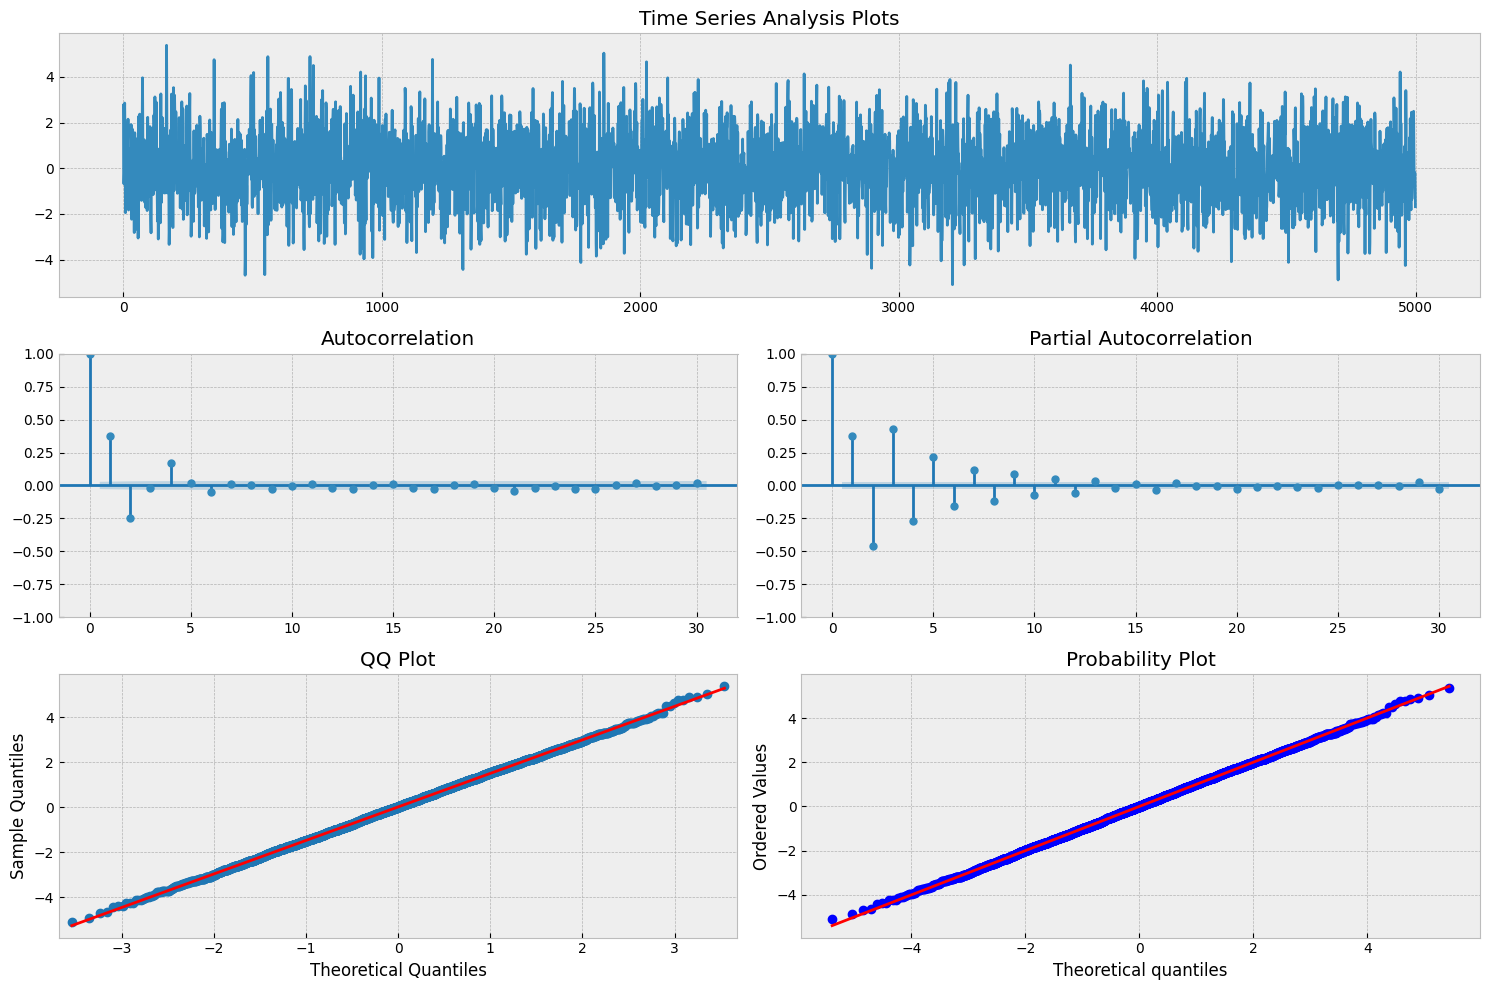

In [14]:
# Simulate an ARMA(3, 2) model with alphas=[0.5,-0.4,0.25] and betas=[0.5,-0.3]

max_lag = 30

n = int(5000)
burn = 2000

alphas = np.array([0.5, -0.4, 0.25])
betas = np.array([0.5, -0.3])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma32, lags=max_lag)

In [ ]:
# pick best order by aic
# smallest aic value wins
best_aic = np.inf
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: %6.5f | order: %s'%(best_aic, best_order))


/Users/chandinijain/Library/Python/2.7/lib/python/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



aic: 14253.90833 | order: (4, 3)


/Users/chandinijain/Library/Python/2.7/lib/python/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)

(array([15.7242009]), array([0.7335802]))

Notice that the p-value is greater than 0.05, which states that the residuals are independent at the 95% level and thus an ARMA(3,2) model provides a good model fit.

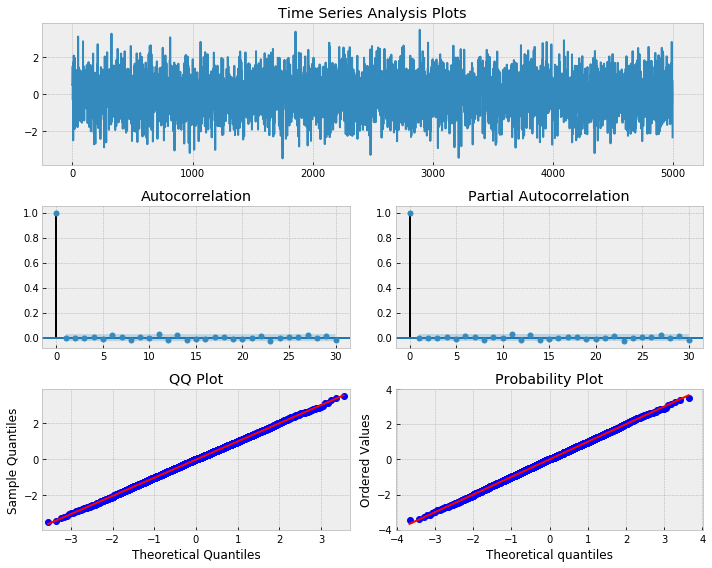

In [ ]:
_ = tsplot(best_mdl.resid, lags=max_lag)

Also the model residuals look like white noise.

In [ ]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed.')

The residuals seem normally distributed.


Next we fit an ARMA model to SPX returns.

/Users/chandinijain/Library/Python/2.7/lib/python/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



aic: -5188.36035 | order: (2, 1)


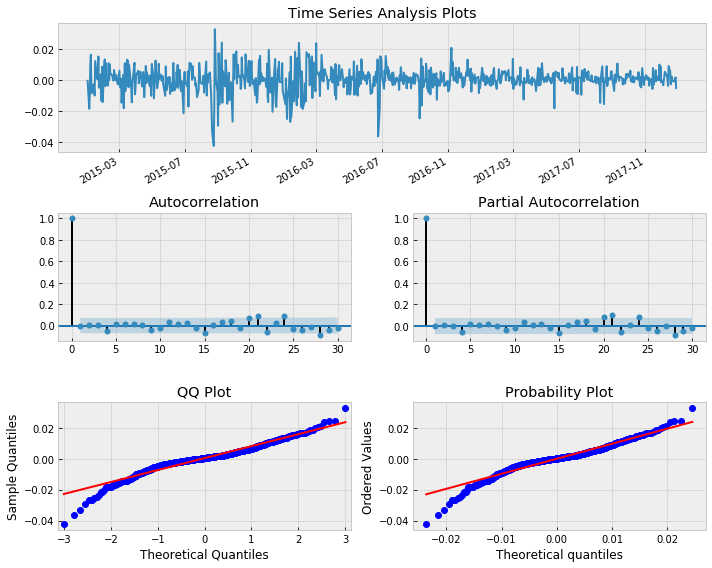

In [ ]:
from numpy.linalg import LinAlgError
# Fit ARMA model to SPX returns

TS = lrets['SPX'].dropna()
TS.index = pd.DatetimeIndex(TS.index.values,
                               freq=TS.index.inferred_freq)

best_aic = np.inf
best_order = None
best_mdl = None

rng = range(1,5) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(TS, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except (ValueError, LinAlgError) as e: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

_ = tsplot(best_mdl.resid, lags=max_lag)


The best fitting model has ARMA(3,2). Notice that there are some significant peaks, especially at higher lags. This is indicative of a poor fit. Let's perform a Ljung-Box test to see if we have statistical evidence for this:

In [ ]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)


(array([17.37533745]), array([0.62848412]))

As we suspected, the p-value is less that 0.05 and as such we cannot say that the residuals are a realisation of discrete white noise. Hence there is additional autocorrelation in the residuals that is not explained by the fitted ARMA(3,2) model. This is obvious from the plot of residuals as well, we can see areas of obvious conditional heteroskedasticity (conditional volatility) that the model has not captured.

### Autoregressive Integrated Moving Average Models - ARIMA(p, d, q)

ARIMA is a natural extension to the class of ARMA models - they are used because they can reduce a non-stationary series to a stationary series using a sequence of differences.

Most of financial TS are not stationary, however they can be made stationary by differencing. We saw an example of this when we took the first difference of nonstationary Guassian random walk and proved that it equals stationary white noise.

ARIMA essentially performs same function, but does so repeatedly, $d$ times, in order to reduce a non-stationary series to a stationary one.

**Without diving too deeply into the equation, just know that a time series $x_t$ is integrated of order $d$ if we difference the series $d$ times and receive a discrete white noise series.**


A time series $x_t$ is an autoregressive integrated moving average model of order p, d, q, ARIMA(p,d,q) if the series $x_t$ is differenced $d$ times, and it then follows an ARMA(p,q) process.

Let's simulate an ARIMA(2,1,1) model, with the $\alpha = [0.5, -0.25], \beta=-0.5$. Like before we will fit an ARIMA model to our simulated data, attempt to recover the parameters.

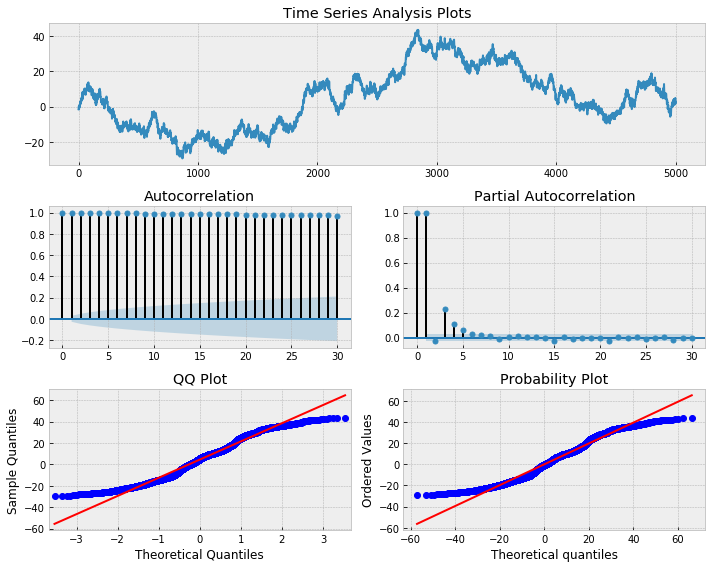

In [ ]:
# Simulate an ARIMA(2,1,1) model with alphas=[0.5,-0.25] and betas=[-0.5]

max_lag = 30

n = int(5000)
burn = 2000

alphas = np.array([0.5,-0.25])
betas = np.array([-0.5])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma11 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
arima111 = arma11.cumsum()
_ = tsplot(arima111, lags=max_lag)

/Users/chandinijain/Library/Python/2.7/lib/python/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/chandinijain/Library/Python/2.7/lib/python/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/chandinijain/Library/Python/2.7/lib/python/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/chandinijain/Library/Python/2.7/lib/python/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



aic: 14263.11094 | order: (4, 1, 3)


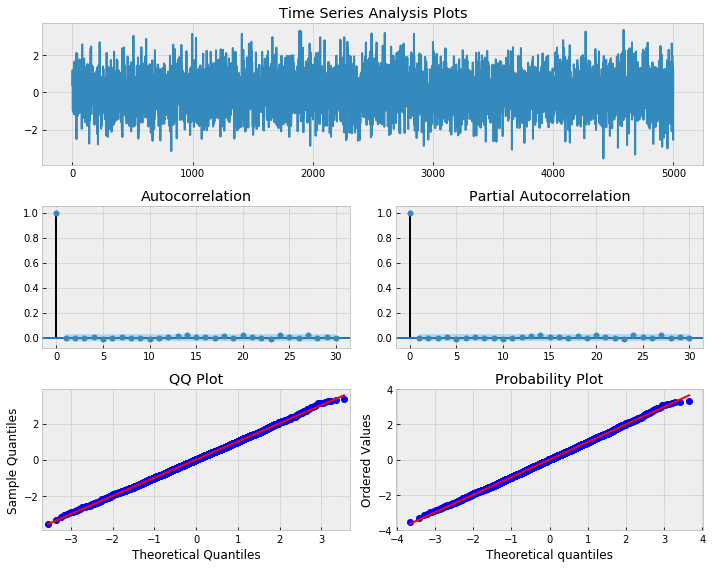

In [ ]:
# Fit ARIMA(p, d, q) model
# pick best order and final model based on aic

best_aic = np.inf
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(arima111, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: %6.5f | order: %s'%(best_aic, best_order))

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

As expected, we predict a ARIMA(2,1,1) model and the residuals looking like a realisation of discrete white noise:

In [ ]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)

(array([6.92380867]), array([0.99692754]))

We perform the Ljung-Box test and find the p-value is significantly larger than 0.05 and as such we can state that there is strong evidence for discrete white noise being a good fit to the residuals. Hence, the ARIMA(2,1,1) model is a good fit. And our standard test for normality on residuals is below.

In [ ]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed.')

The residuals seem normally distributed.


In the following example, we iterate through a non-trivial number of combinations of (p, d, q) orders, to find the best ARIMA model to fit SPX returns. We use the AIC to evaluate each model. The lowest AIC wins.

/Users/chandinijain/Library/Python/2.7/lib/python/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/chandinijain/Library/Python/2.7/lib/python/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/chandinijain/Library/Python/2.7/lib/python/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Users/chandinijain/Library/Python/2.7/lib/python/site-packages/statsmodels/base/model.py:496: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



aic: -5188.75603 | order: (4, 0, 0)


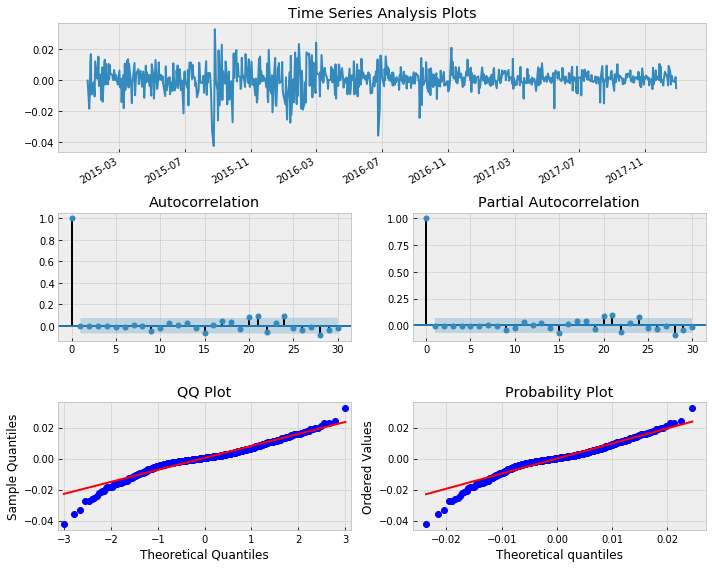

In [ ]:
# Fit ARIMA(p, d, q) model to SPX log returns
# pick best order and final model based on aic

TS = lrets['^GSPC'].dropna()
TS.index = pd.DatetimeIndex(TS.index.values,
                               freq=TS.index.inferred_freq)

best_aic = np.inf
best_order = None
best_mdl = None


pq_rng = range(5) # [0,1,2,3]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

It should be no surprise that the best model has a differencing of 0. Recall that we already took the first difference of log prices to calculate the stock returns. The result is essentially identical to the ARMA(3, 2) model we fit above. Clearly this ARIMA model has not explained the conditional volatility in the series either! The ljung box test below also shows a pvalue of less than 0.05

In [ ]:
sms.diagnostic.acorr_ljungbox(best_mdl.resid, lags=[20], boxpierce=False)

(array([16.29335679]), array([0.69826621]))

#### Excluding periods of conditional Volatility

Let's try the same model on SPX data from 2010-2016

Our residuals look much closer to white noise and the p-value of our test is now greater than 0.05! How did our model suddenly improve?

In [ ]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print('We have reason to suspect the residuals are not normally distributed.')
else:
    print('The residuals seem normally distributed.')

The residuals seem normally distributed.


If we deliberately select from the S&P500 data to start from non volatile periods (excluding covid or 2007-2008 for example), our resiudals would look much closer to white noise and the p-value of our test would show improve. Hence

*This is a very important point*. When analysing time series we need to be extremely careful of conditionally heteroscedastic series, such as stock market indexes. In quantitative finance, trying to determine periods of differing volatility is often known as "regime detection". It is one of the harder tasks to achieve!

#### Forecasting

We use statmodels forecast() method - we need to provide the number of time steps to predict, and a decimal for the alpha argument to specify the confidence intervals. The default setting is 95% confidence. For 99% set alpha equal to 0.01.

In [ ]:
# Create a 21 day forecast of SPX returns with 95%, 99% CI
n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(data.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]),
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]),
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2017-12-29,0.000592,-0.016727,-0.022169,0.017911,0.023353
2017-12-30,0.000704,-0.016625,-0.022071,0.018034,0.023479
2017-12-31,0.000546,-0.016793,-0.022242,0.017885,0.023333
2018-01-01,-0.000285,-0.017654,-0.023111,0.017083,0.022541
2018-01-02,0.001123,-0.016287,-0.021757,0.018532,0.024003


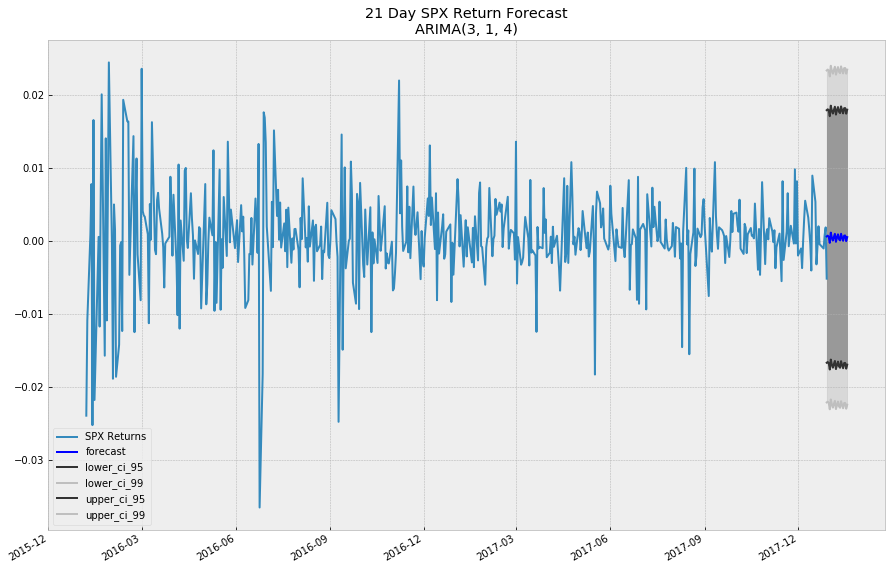

In [ ]:
# Plot 21 day forecast for SPX returns

plt.style.use('bmh')
fig = plt.figure(figsize=(15,10))
ax = plt.gca()

ts = lrets['^GSPC'].iloc[-500:].copy()
ts.plot(ax=ax, label='SPX Returns')
# in sample prediction
#pred = best_mdl.predict(ts.index[0], ts.index[-1])
#pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day SPX Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)

We learn the ability to fit and forecast models such as ARIMA that help us to fit much better our data. In the next notebook we are going to take a look at the Generalised Autoregressive Conditional Heteroscedasticity (GARCH) model and use it to explain more of the serial correlation.